# Import Evaluation Metrics

In [1]:
!pip install pycocoevalcap
!pip install torch torchaudio transformers moviepy opencv-python ultralytics
!pip install moviepy
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.1/800.1 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 45.7 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=e4ea958c63d4975c7ebc5e28d95e329923ee20e3ced9cc2c2404869ba0b6dfec
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependen

# Import Libraries

In [2]:
import os
import cv2
import numpy as np
import sys
import glob
import json
import h5py
from tqdm import tqdm
import pickle
import random
import itertools
from PIL import Image
import warnings
import re
import unicodedata
import math
import time
import matplotlib.pyplot as plt
import copy
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from torch.nn import functional as F
from torch import optim

In [3]:
warnings.filterwarnings('ignore')

# Create Paths

In [4]:
saved_path = '/kaggle/working/Saved'
if not os.path.exists(saved_path):
    os.makedirs(saved_path)
    print("Directory 'Saved' created successfully.")
else:
    print("Directory 'Saved' already exists.")

prediction_path = '/kaggle/working/results'
if not os.path.exists(prediction_path):
    os.makedirs(prediction_path)
    print("Directory 'results' created successfully.")
else:
    print("Directory 'results' already exists.")

Directory 'Saved' created successfully.
Directory 'results' created successfully.


In [5]:
class Path:
    def __init__(self,cfg,working_path):

        if cfg.dataset == 'msvd':
            self.local_path = os.path.join(working_path,'MSVD')
            self.video_path = 'path_to_raw_video_data' # For future use
            self.caption_path = '/kaggle/input/video-captions/captions'
            self.feature_path = '/kaggle/input/new-video-features'

            self.name_mapping_file = os.path.join(self.caption_path,'youtube_mapping.txt')
            self.train_annotation_file = os.path.join(self.caption_path,'sents_train_lc_nopunc.txt')
            self.val_annotation_file = os.path.join(self.caption_path,'sents_val_lc_nopunc.txt')
            self.test_annotation_file = os.path.join(self.caption_path,'sents_test_lc_nopunc.txt')

            if cfg.appearance_feature_extractor == 'inceptionresnetv2':
                self.appearance_feature_file = os.path.join(self.feature_path,'MSVD_APPEARANCE_INCEPTIONRESNETV2_28_NEW.hdf5')




        self.prediction_path = prediction_path
        self.saved_models_path = saved_path

# Configure Model

In [6]:
class ConfigSALSTM:
    '''
    Hyperparameter settings for Soft Attention based LSTM (SA-LSTM) model.
    '''
    def __init__(self,model_name='sa-lstm',opt_encoder=False):
        self.model_name = model_name
        
        #Device configuration
        self.cuda_device_id = 0
        if torch.cuda.is_available():
            self.device = torch.device('cuda:'+str(self.cuda_device_id))
        else:
            self.device = torch.device('cpu')
            
        #Dataloader configuration
        self.dataset = 'msvd'
        self.batch_size = 100 #suitable
        self.val_batch_size = 10
        self.opt_truncate_caption = True
        self.max_caption_length = 30
        
#         self.dropout=0.01
        
        
        #Encoder configuration
        self.appearance_feature_extractor = 'inceptionresnetv2'
        self.appearance_input_size = 1536
        self.appearance_projected_size = 512
        self.frame_len = 28
        self.opt_encoder = opt_encoder
        
        
        #Decoder configuration
        self.decoder_type = 'lstm'
        self.embedding_size = 468 # word embedding size
        if self.opt_encoder:
            self.feat_size =  self.appearance_projected_size
        else:
            self.feat_size = self.appearance_input_size
            
        self.decoder_input_size = self.feat_size + self.embedding_size
        self.decoder_hidden_size = 512  #Hidden size of decoder LSTM
        self.attn_size = 128  # attention bottleneck
        self.n_layers = 1
        self.embed_dropout = 0.5
        self.rnn_dropout = 0.4
        self.opt_param_init = False
        self.beam_length = 5
        
        #Training configuration
    
        self.encoder_lr = 1e-4
        self.decoder_lr = 1e-4
        self.teacher_forcing_ratio = 1.0 #
        self.clip = 5 # clip the gradient to counter exploding gradient problem
        self.print_every = 40
        
        self.lr_decay_start_from = 20
        self.lr_decay_gamma = 0.5
        self.lr_decay_patience = 5
        self.weight_decay = 1e-5
        self.reg_lambda = 0.
        
        #Vocabulary configuration
        self.SOS_token = 1
        self.EOS_token = 2
        self.PAD_token = 0
        self.UNK_token = 3
        self.vocabulary_min_count = 5

# Create DataHandler

In [7]:
def collate_fn(batch): # add support for motion and object features
    '''
    Custom collate function for supporting batching during training and inference. 
    '''
   
    data=[item[0] for item in batch]
    images=torch.stack(data,0)    
    label=[item[1] for item in batch]
    ides = [item[2] for item in batch]
    
    motion = [item[3] for item in batch]
    motion_batch = torch.stack(motion,0)
    
    object_ = [item[4] for item in batch]
    object_batch = torch.stack(object_,0)

    max_target_len = max([len(indexes) for indexes in label])
    padList = list(itertools.zip_longest(*label, fillvalue = 0))

    lengths = torch.tensor([len(p) for p in label])
    padVar = torch.LongTensor(padList)

    m = []
    for i, seq in enumerate(padVar):
        #m.append([])
        tmp = []
        for token in seq:
            if token == 0:
                tmp.append(int(0))
            else:
                tmp.append(1)
        m.append(tmp)
    m = torch.tensor(m)
    
    return images,padVar,m,max_target_len,ides,motion_batch,object_batch

In [8]:
class CustomDataset(Dataset):

    def __init__(self,cfg,appearance_feature_dict, annotation_dict , video_name_list, voc,motion_feature_dict=None,
                     object_feature_dict=None):

        self.annotation_dict = annotation_dict
        self.appearance_feature_dict = appearance_feature_dict
        self.v_name_list = video_name_list
        self.voc = voc
        self.max_caption_length = cfg.max_caption_length
        self.motion_feature_dict = motion_feature_dict
        self.object_feature_dict = object_feature_dict
        self.opt_truncate_caption = cfg.opt_truncate_caption

    def __len__(self):
        return len(self.v_name_list)

    def __getitem__(self,idx):

        anno = random.choice(self.annotation_dict[self.v_name_list[idx]])
        anno_index = []
        for word in anno.split(' '):
            try:
                anno_index.append(self.voc.word2index[word])
            except:
                pass
        if self.opt_truncate_caption:
            if len(anno_index)> self.max_caption_length:
                anno_index = anno_index[:self.max_caption_length]
        anno_index = anno_index + [self.voc.cfg.EOS_token]

        appearance_tensor = torch.tensor(self.appearance_feature_dict[self.v_name_list[idx]]).float()

        if self.motion_feature_dict == None:
            motion_tensor = torch.zeros_like(appearance_tensor)
        else:
             motion_tensor = torch.tensor(self.motion_feature_dict[self.v_name_list[idx]]).float()
        if self.object_feature_dict == None:
            object_tensor = torch.zeros_like(appearance_tensor)
        else:
            object_tensor = torch.tensor(self.object_feature_dict[self.v_name_list[idx]]).float()

        return appearance_tensor,anno_index, self.v_name_list[idx],motion_tensor,object_tensor

In [9]:
class DataHandler:

    def __init__(self,cfg,path,voc):

        self.voc = voc
        self.cfg = cfg
        self.path = path
        self.appearance_feature_dict = {}

        if cfg.dataset == 'msvd':  # For MSVD dataset

            self._msvd_create_dict() # Reference caption dictionaries
            # read appearance feature file
            self.appearance_feature_dict = self._read_feature_file(feature_type='appearance')

        self.train_name_list = list(self.train_dict.keys())
        self.val_name_list = list(self.val_dict.keys())
        self.test_name_list = list(self.test_dict.keys())

    def _read_feature_file(self,feature_type='appearance'):

        feature_dict = {}
        if feature_type == 'appearance':
            f1 = h5py.File(self.path.appearance_feature_file,'r')
        elif feature_type == 'motion':
            f1 = h5py.File(self.path.motion_feature_file,'r+')
        else:
            f1 = h5py.File(self.path.object_feature_file,'r+')

        if self.cfg.model_name == 'sa-lstm' or self.cfg.model_name == 'recnet':
            for key in f1.keys():
                arr = f1[key][()]
                if arr.shape[0] < self.cfg.frame_len:
                    pad = self.cfg.frame_len - arr.shape[0]
                    arr = np.concatenate((arr,np.zeros((pad,arr.shape[1]))),axis = 0)
                feature_dict[key] = arr

        if self.cfg.model_name == 'mean_pooling':
            for key in f1.keys():
                feature_dict[key] = f1[key].value.mean(axis=0)

        return feature_dict

    def _file_to_dict(self,path):
        dic = dict()
        fil = open(path,'r')
        for f in fil.readlines():
            l = f.split()
            ll = ' '.join(x for x in l[1:])
            if l[0] not in dic:
                dic[l[0]] = [ll]
            else:
                dic[l[0]].append(ll)
        return dic

    def _name_mapping(self,path):
        vid2url = dict()
        fil = open(path.name_mapping_file,'r+')
        for f in fil.readlines():
            l = f.split(' ')
            vid2url[l[1].strip('\n')] = l[0]
        return vid2url

    def _msvd_create_dict(self):
        self.train_dict = self._file_to_dict(self.path.train_annotation_file)
        self.val_dict = self._file_to_dict(self.path.val_annotation_file)
        self.test_dict = self._file_to_dict(self.path.test_annotation_file)


    def getDatasets(self):

        if self.cfg.model_name == 'mean_pooling' or self.cfg.model_name == 'sa-lstm' or self.cfg.model_name == 'recnet':
            train_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.train_dict, self.train_name_list, self.voc)
            val_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.val_dict, self.val_name_list, self.voc)
            test_dset = CustomDataset(self.cfg,self.appearance_feature_dict, self.test_dict, self.test_name_list, self.voc)


        return train_dset, val_dset, test_dset

    def getDataloader(self,train_dset,val_dset,test_dset):

        train_loader=DataLoader(train_dset,batch_size = self.cfg.batch_size, num_workers = 8,shuffle = True,
                        collate_fn = collate_fn, drop_last=True)

        val_loader = DataLoader(val_dset,batch_size = 10, num_workers = 8,shuffle = False,collate_fn = collate_fn,
                         drop_last=False)
        test_loader = DataLoader(test_dset,batch_size = 10, num_workers = 8,shuffle = False,collate_fn = collate_fn,
                         drop_last=False)

        return train_loader,val_loader,test_loader

# Utils

In [10]:
class Utils:
    '''
    Generic utility functions that our model and dataloader would require

    '''
   
    @staticmethod
    def set_seed(seed):
        '''
          For reproducibility 
        '''
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    @staticmethod
    def unicodeToAscii(s):
        '''
        Turn a Unicode string to plain ASCII, 
        Thanks to https://stackoverflow.com/a/518232/2809427
        '''
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

    @staticmethod
    def normalizeString(s):
        '''
        Lowercase, trim, and remove non-letter 
        '''
        s = unicodeToAscii(s.lower().strip())
        s = re.sub(r"([.!?])", r" \1", s)
        s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
        return s

    @staticmethod
    def target_tensor_to_caption(voc,target):
        '''
        Convert target tensor to Caption
        '''
        gnd_trh = []
        lend = target.size()[1]
        for i in range(lend):
            tmp = ' '.join(voc.index2word[x.item()] for x in target[:,i])
            gnd_trh.append(tmp)
        return gnd_trh

    @staticmethod
    def maskNLLLoss(inp, target, mask, device):
        '''
        Masked cross-entropy loss calculation; 
        refers: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html
        '''
        inp = inp.squeeze(0)
        nTotal = mask.sum()
        mask = mask.bool() #Updated 
        crossEntropy = -torch.log(torch.gather(inp.squeeze(0), 1, target.view(-1, 1)).squeeze(1).float())
        loss = crossEntropy.masked_select(mask).mean()
        loss = loss.to(device)
        return loss, nTotal.item()
 
    @staticmethod
    def score(ref, hypo):
        """
        ref, dictionary of reference sentences (id, sentence)
        hypo, dictionary of hypothesis sentences (id, sentence)
        score, dictionary of scores
        refers: https://github.com/zhegan27/SCN_for_video_captioning/blob/master/SCN_evaluation.py
        """
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]
        final_scores = {}
        for scorer, method in scorers:
            score, scores = scorer.compute_score(ref, hypo)
            if type(score) == list:
                for m, s in zip(method, score):
                    final_scores[m] = s
            else:
                final_scores[method] = score
        return final_scores

    @staticmethod
    def FrameCapture(video_path, video_name):
        '''
        Function to extract frames
        For MSVD Sample every 10th frame
        '''
        
        #video_path = video_path_dict[video_name]
        # Path to video file 
        video_path = video_path+video_name  #Changes
        vidObj = cv2.VideoCapture(video_path) 
        count = 0
        fail = 0
        # checks whether frames were extracted 
        success = 1
        frames = []
        while success: 
            # OpenCV Uses BGR Colormap
            success, image = vidObj.read() 
            try:
                RGBimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if count%10 == 0:            #Sample 1 frame per 10 frames
                    frames.append(RGBimage)
                count += 1
            except:
                fail += 1
        vidObj.release()
        if count > 80:
            frames = frames[:81]
        return np.stack(frames[:-1]),count-1, fail

    @staticmethod
    def imshow(img):
        '''
        Shows a grid of images
        '''
        #img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Create Vocabulary

In [11]:
class Vocabulary:

    def __init__(self, cfg):
        self.name = cfg.dataset
        self.cfg = cfg
        self.trimmed = False
        self.word2index = {"PAD":cfg.PAD_token,"EOS":cfg.EOS_token,"SOS":cfg.SOS_token, "UNK":cfg.UNK_token}
        self.word2count = {}
        self.index2word = {cfg.PAD_token:"PAD",cfg.EOS_token:"EOS",cfg.SOS_token:"SOS", cfg.UNK_token:"UNK"}
        self.num_words = 4

    def addSentence(self,sentence): #Add Sentence to vocabulary
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):  # Add words to vocabulary
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            if self.trimmed == False:
                self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            if self.trimmed == False:
                self.word2count[word] += 1

    def save(self,word2index_dic = 'word2index_dic.p', index2word_dic = 'index2word_dic.p',
         word2count_dic = 'word2count_dic.p'):

        # Create the "Saved" directory if it doesn't exist
        saved_dir = saved_path
        os.makedirs(saved_dir, exist_ok=True)

        w2i = os.path.join(saved_dir, self.name + '_' + word2index_dic)
        i2w = os.path.join(saved_dir, self.name + '_' + index2word_dic)
        w2c = os.path.join(saved_dir, self.name + '_' + word2count_dic)
        try:
            with open(w2i, 'wb') as fp:
                pickle.dump(self.word2index, fp, protocol=pickle.HIGHEST_PROTOCOL)

            with open(i2w, 'wb') as fp:
                pickle.dump(self.index2word, fp, protocol=pickle.HIGHEST_PROTOCOL)

            with open(w2c, 'wb') as fp:
                pickle.dump(self.word2count, fp, protocol=pickle.HIGHEST_PROTOCOL)
        except:
            print('Path Error, Verify the path of the filename is correct')



    def load(self, word2index_dic = 'word2index_dic.p', index2word_dic = 'index2word_dic.p',
             word2count_dic = 'word2count_dic.p'):

        w2i = os.path.join('Saved',self.name+'_'+word2index_dic)
        i2w = os.path.join('Saved',self.name+'_'+index2word_dic)
        w2c = os.path.join('Saved',self.name+'_'+word2count_dic)

        try:
            with open(w2i, 'rb') as fp:
                self.word2index = pickle.load(fp)

            with open(i2w, 'rb') as fp:
                self.index2word = pickle.load(fp)

            with open(w2c, 'rb') as fp:
                self.word2count = pickle.load(fp)

            self.num_words = len(self.word2index)

        except:
            print('File loading error.. check the path or filename is correct')


    def trim(self, min_count):  # Trim Rare words with frequency less than min_count
        if self.trimmed:
            print('Already trimmed before')
            return 0
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {"PAD":self.cfg.PAD_token,"EOS":self.cfg.EOS_token,"SOS":self.cfg.SOS_token, "UNK":self.cfg.UNK_token}
        #self.word2count = {}
        self.index2word = {self.cfg.PAD_token:"PAD",self.cfg.EOS_token:"EOS",self.cfg.SOS_token:"SOS", self.cfg.UNK_token:"UNK"}
        self.num_words = 4

        for word in keep_words:
            self.addWord(word)
            if word not in self.word2count:
                del self.word2count[word]

# SA-LSTM Model

In [12]:
class Encoder(nn.Module):

    def __init__(self,cfg):
        super(Encoder,self).__init__()
        '''
        Encoder module. Project the video feature into a different space which will be
        send to decoder.
        Argumets:
          input_size : CNN extracted feature size. For Densenet 1920, For inceptionv4 1536
          output_size : Dimention of projected space.
        '''

        self.appearance_projection_layer = nn.Linear(cfg.appearance_input_size,cfg.appearance_projected_size)


    def forward(self,x):
        appearance_out = self.appearance_projection_layer(x)
        return appearance_out


class TemporalAttention(nn.Module):
    def __init__(self,cfg):
        super(TemporalAttention,self).__init__()
        '''
        Spatial Attention module. It depends on previous hidden memory in the decoder(of shape hidden_size),
        feature at the source side ( of shape(196,feat_size) ).
        at(s) = align(ht,hs)
              = exp(score(ht,hs)) / Sum(exp(score(ht,hs')))
        where
        score(ht,hs) = ht.t * hs                         (dot)
                     = ht.t * Wa * hs                  (general)
                     = va.t * tanh(Wa[ht;hs])           (concat)
        Here we have used concat formulae.
        Argumets:
          hidden_size : hidden memory size of decoder. (batch,hidden_size)
          feat_size : feature size of each grid (annotation vector) at encoder side.
          bottleneck_size : intermediate size.
        '''


        self.hidden_size = cfg.decoder_hidden_size
        self.feat_size = cfg.feat_size
        self.bottleneck_size = cfg.attn_size

        self.decoder_projection = nn.Linear(self.hidden_size,self.bottleneck_size)
        self.encoder_projection = nn.Linear(self.feat_size, self.bottleneck_size)
        self.final_projection = nn.Linear(self.bottleneck_size,1)

    def forward(self,hidden,feats):
        '''
        shape of hidden (hidden_size) (batch,hidden_size) #(100,512)
        shape of feats (batch size,
        ,feat_size)  #(100,40,1536)
        '''
        Wh = self.decoder_projection(hidden)
        Uv = self.encoder_projection(feats)
        Wh = Wh.unsqueeze(1).expand_as(Uv)
        energies = self.final_projection(torch.tanh(Wh+Uv))
        weights = F.softmax(energies, dim=1)
        weighted_feats = feats *weights.expand_as(feats)
        attn_feats = weighted_feats.sum(dim=1)
        return attn_feats,weights


class DecoderRNN(nn.Module):

    def __init__(self,cfg,voc):
        super(DecoderRNN, self).__init__()
        '''
        Decoder, Basically a language model.
        Args:
        hidden_size : hidden memory size of LSTM/GRU
        output_size : output size. Its same as the vocabulary size.
        n_layers :

        '''

        # Keep for reference


        # Keep for reference
        self.dropout = cfg.dropout
        self.feat_len = cfg.frame_len
        self.attn_size = cfg.attn_size
        self.output_size = voc.num_words
        self.rnn_dropout = cfg.rnn_dropout
        self.n_layers = cfg.n_layers
        self.decoder_type = cfg.decoder_type

        # Define layers
        self.embedding = nn.Embedding(voc.num_words, cfg.embedding_size)
        self.attention = TemporalAttention(cfg)
        self.embedding_dropout = nn.Dropout(cfg.dropout)
        if self.decoder_type == 'gru':
            self.rnn = nn.GRU(input_size=cfg.decoder_input_size, hidden_size=cfg.decoder_hidden_size,
                              num_layers=self.n_layers, dropout=self.rnn_dropout)
        else:
            self.rnn = nn.LSTM(input_size=cfg.decoder_input_size, hidden_size=cfg.decoder_hidden_size,
                           num_layers=self.n_layers, dropout=self.rnn_dropout)
        self.out = nn.Linear(cfg.decoder_hidden_size, self.output_size)


    def forward(self, inputs, hidden, feats):
        '''
        we run this one step (word) at a time

        inputs -  (1, batch)
        hidden - h_n/c_n :(num_layers * num_directions, batch, hidden_size)    # GRU:h_n   LSTM:(h_n,c_n)
        feats - (batch,attention_length,annotation_vector_size)

        '''
        embedded = self.embedding(inputs) # [i/p:(1,batch)  o/p:(1,batch,embedding_size)]
        last_hidden = hidden[0] if self.decoder_type=='lstm' else hidden
        last_hidden = last_hidden.view(self.n_layers,last_hidden.size(1),last_hidden.size(2))
        last_hidden = last_hidden[-1]
        feats, attn_weights = self.attention(last_hidden,feats) #(100,1536) #(100,28,1)
        input_combined = torch.cat((embedded,feats.unsqueeze(0)),dim=2)
        output, hidden = self.rnn(input_combined, hidden) # (1,100,512)
        output = output.squeeze(0) # (100,512)
        output = self.out(output) # (100,num_words)
        output = F.softmax(output, dim = 1) #(100,num_words)
        return output, hidden, attn_weights




class SALSTM(nn.Module):

    def __init__(self,voc,cfg,path):
        super(SALSTM,self).__init__()

        self.voc = voc
        self.path = path
        self.cfg = cfg

        if cfg.opt_encoder:
            self.encoder = Encoder(cfg).to(cfg.device)
            self.enc_optimizer = optim.Adam(self.encoder.parameters(),lr=cfg.encoder_lr)

        self.decoder = DecoderRNN(cfg,voc).to(cfg.device)
        self.dec_optimizer = optim.Adam(self.decoder.parameters(),lr=cfg.decoder_lr,weight_decay=cfg.weight_decay,amsgrad=True)

        self.teacher_forcing_ratio = cfg.teacher_forcing_ratio
        self.print_every = cfg.print_every
        self.clip = cfg.clip
        self.device = cfg.device
        if cfg.opt_param_init:
            self.init_params()


    def init_params(self):
        for name, param in self.decoder.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
                #nn.init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')



    def update_hyperparameters(self,cfg):

        if self.cfg.opt_encoder:
            self.enc_optimizer = optim.Adam(self.encoder.parameters(),lr=cfg.encoder_lr)

        self.dec_optimizer = optim.Adam(self.decoder.parameters(),lr=cfg.decoder_lr,amsgrad=True)
        self.teacher_forcing_ratio = cfg.teacher_forcing_ratio


    def load(self,encoder_path = 'Save/Meanpool_10.pt',decoder_path='Saved/SALSTM_10.pt'):
        if os.path.exists(encoder_path) and os.path.exists(decoder_path):
            self.encoder.load_state_dict(torch.load(encoder_path))
            self.decoder.load_state_dict(torch.load(decoder_path))
        else:
            print('File not found Error..')

    def save(self,encoder_path,decoder_path):
        if os.path.exists(encoder_path) and os.path.exists(decoder_path):

            torch.save(model.encoder.state_dict(),encoder_path)
            torch.save(model.decoder.state_dict(),decoder_path)
        else:
            print('Invalid path address given.')

    def train_epoch(self,dataloader,utils):
        '''
        Function to train the model for a single epoch.
        Args:
         Input:
            dataloader : the dataloader object.basically train dataloader object.
         Return:
             epoch_loss : Average single time step loss for an epoch
        '''
        total_loss = 0
        start_iteration = 1
        print_loss = 0
        iteration = 1
        if self.cfg.opt_encoder:
            self.encoder.train()
        self.decoder.train()
        for data in dataloader:
            features, targets, mask, max_length, _,_,_ = data
            use_teacher_forcing = True if random.random() < self.teacher_forcing_ratio else False
            loss = self.train_iter(utils,features,targets,mask,max_length,use_teacher_forcing)
            print_loss += loss
            total_loss += loss
        # Print progress
            if iteration % self.print_every == 0:
                print_loss_avg = print_loss / self.print_every
                print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".
                format(iteration, iteration / len(dataloader) * 100, print_loss_avg))
                print_loss = 0


            iteration += 1
        return total_loss/len(dataloader)


    def train_iter(self,utils,input_variable, target_variable, mask,max_target_len,use_teacher_forcing):
        '''
        Forward propagate input signal and update model for a single iteration.

        Args:
        Inputs:
            input_variable : video mini-batch tensor; size = (B,T,F)
            target_variable : Ground Truth Captions;  size = (T,B); T will be different for different mini-batches
            mask : Masked tensor for Ground Truth;    size = (T,C)
            max_target_len : maximum lengh of the mini-batch; size = T
            use_teacher_forcing : binary variable. If True training uses teacher forcing else sampling.
            clip : clip the gradients to counter exploding gradient problem.
        Returns:
            iteration_loss : average loss per time step.
        '''
        if self.cfg.opt_encoder:
            self.enc_optimizer.zero_grad()
        self.dec_optimizer.zero_grad()

        loss = 0
        print_losses = []
        n_totals = 0

        input_variable = input_variable.to(self.device)

        if self.cfg.opt_encoder:
            input_variable = self.encoder(input_variable)
        target_variable = target_variable.to(self.device)
        mask = mask.byte().to(self.device)

        # Forward pass through encoder
        decoder_input = torch.LongTensor([[self.cfg.SOS_token for _ in range(self.cfg.batch_size)]])
        decoder_input = decoder_input.to(self.device)
        decoder_hidden = torch.zeros(self.cfg.n_layers, self.cfg.batch_size,
                                      self.cfg.decoder_hidden_size).to(self.device)
        if self.cfg.decoder_type == 'lstm':
            decoder_hidden = (decoder_hidden,decoder_hidden)


        # Forward batch of sequences through decoder one time step at a time
        if use_teacher_forcing:
            for t in range(max_target_len):
                decoder_output, decoder_hidden,_ = self.decoder(decoder_input, decoder_hidden,input_variable.float())
                # Teacher forcing: next input comes from ground truth(data distribution)
                decoder_input = target_variable[t].view(1, -1)
                mask_loss, nTotal = utils.maskNLLLoss(decoder_output.unsqueeze(0), target_variable[t], mask[t],self.device)
                loss += mask_loss
                print_losses.append(mask_loss.item() * nTotal)
                n_totals += nTotal
        else:
            for t in range(max_target_len):
                decoder_output, decoder_hidden,_ = self.decoder(decoder_input, decoder_hidden,input_variable.float())
                # No teacher forcing: next input is decoder's own current output(model distribution)
                _, topi = decoder_output.squeeze(0).topk(1)
                decoder_input = torch.LongTensor([[topi[i][0] for i in range(self.cfg.batch_size)]])
                decoder_input = decoder_input.to(self.device)
                # Calculate and accumulate loss
                mask_loss, nTotal = utils.maskNLLLoss(decoder_output, target_variable[t], mask[t],self.device)
                loss += mask_loss
                print_losses.append(mask_loss.item() * nTotal)
                n_totals += nTotal

        # Perform backpropatation
        loss.backward()

        if self.cfg.opt_encoder:
            _ = nn.utils.clip_grad_norm_(self.encoder.parameters(), self.clip)
            self.enc_optimizer.step()

        _ = nn.utils.clip_grad_norm_(self.decoder.parameters(), self.clip)
        self.dec_optimizer.step()


        return sum(print_losses) / n_totals


    @torch.no_grad()
    def GreedyDecoding(self,features,max_length=15):
        batch_size = features.size()[0]
        features = features.to(self.device)

        if self.cfg.opt_encoder:
            features = self.encoder(features) #need to make optional
        decoder_input = torch.LongTensor([[self.cfg.SOS_token for _ in range(batch_size)]]).to(self.device)
        decoder_hidden = torch.zeros(self.cfg.n_layers, batch_size,
                                      self.cfg.decoder_hidden_size).to(self.device)
        if self.cfg.decoder_type == 'lstm':
            decoder_hidden = (decoder_hidden,decoder_hidden)
        caption = []
        attention_values = []
        for _ in range(max_length):
            decoder_output, decoder_hidden,attn_values = self.decoder(decoder_input,
                                                            decoder_hidden,features.float())
            _, topi = decoder_output.squeeze(0).topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]]).to(self.device)
            caption.append(topi.squeeze(1).cpu())
            attention_values.append(attn_values.squeeze(2))
        caption = torch.stack(caption,0).permute(1,0)
        caps_text = []
        for dta in caption:
            tmp = []
            for token in dta:
                if token.item() not in self.voc.index2word.keys() or token.item()==2: # Remove EOS and bypass OOV
                    pass
                else:
                    tmp.append(self.voc.index2word[token.item()])
            tmp = ' '.join(x for x in tmp)
            caps_text.append(tmp)
        return caption,caps_text, torch.stack(attention_values,0).cpu().numpy()
    @torch.no_grad()
    def BeamDecoding(self,feats, width, alpha=0.,max_caption_len = 15):
        batch_size = feats.size(0)
        vocab_size = self.voc.num_words
        

        vfunc = np.vectorize(lambda t: self.voc.index2word[t]) # to transform tensors to words
        rfunc = np.vectorize(lambda t: '' if t == 'EOS' else t) # to transform EOS to null string
        lfunc = np.vectorize(lambda t: '' if t == 'SOS' else t) # to transform SOS to null string
        pfunc = np.vectorize(lambda t: '' if t == 'PAD' else t) # to transform PAD to null string
        
        if self.cfg.opt_encoder:
            feats = self.encoder(feats) 

        hidden = torch.zeros(self.cfg.n_layers, batch_size, self.cfg.decoder_hidden_size).to(self.device)
        if self.cfg.decoder_type == 'lstm':
            hidden = (hidden,hidden)
        
        input_list = [ torch.cuda.LongTensor(1, batch_size).fill_(self.cfg.SOS_token) ]
        hidden_list = [ hidden ]
        cum_prob_list = [ torch.ones(batch_size).cuda() ]
        cum_prob_list = [ torch.log(cum_prob) for cum_prob in cum_prob_list ]
        EOS_idx = self.cfg.EOS_token

        output_list = [ [[]] for _ in range(batch_size) ]
        for t in range(max_caption_len + 1):
            beam_output_list = [] # width x ( 1, 100 )
            normalized_beam_output_list = [] # width x ( 1, 100 )
            if self.cfg.decoder_type == "lstm":
                beam_hidden_list = ( [], [] ) # 2 * width x ( 1, 100, 512 )
            else:
                beam_hidden_list = [] # width x ( 1, 100, 512 )
            next_output_list = [ [] for _ in range(batch_size) ]
            assert len(input_list) == len(hidden_list) == len(cum_prob_list)
            for i, (input, hidden, cum_prob) in enumerate(zip(input_list, hidden_list, cum_prob_list)):
                output, next_hidden, _ = self.decoder(input, hidden, feats) # need to check

                caption_list = [ output_list[b][i] for b in range(batch_size)]
                EOS_mask = [ 0. if EOS_idx in [ idx.item() for idx in caption ] else 1. for caption in caption_list ]
                EOS_mask = torch.cuda.FloatTensor(EOS_mask)
                EOS_mask = EOS_mask.unsqueeze(1).expand_as(output)
                output = EOS_mask * output

                output += cum_prob.unsqueeze(1)
                beam_output_list.append(output)

                caption_lens = [ [ idx.item() for idx in caption ].index(EOS_idx) + 1 if EOS_idx in [ idx.item() for idx in caption ] else t + 1 for caption in caption_list ]
                caption_lens = torch.cuda.FloatTensor(caption_lens)
                normalizing_factor = ((5 + caption_lens) ** alpha) / (6 ** alpha)
                normalizing_factor = normalizing_factor.unsqueeze(1).expand_as(output)
                normalized_output = output / normalizing_factor
                normalized_beam_output_list.append(normalized_output)
                if self.cfg.decoder_type == "lstm":
                    beam_hidden_list[0].append(next_hidden[0])
                    beam_hidden_list[1].append(next_hidden[1])
                else:
                    beam_hidden_list.append(next_hidden)
            beam_output_list = torch.cat(beam_output_list, dim=1) # ( 100, n_vocabs * width )
            normalized_beam_output_list = torch.cat(normalized_beam_output_list, dim=1)
            beam_topk_output_index_list = normalized_beam_output_list.argsort(dim=1, descending=True)[:, :width] # ( 100, width )
            topk_beam_index = beam_topk_output_index_list // vocab_size # ( 100, width )
            topk_output_index = beam_topk_output_index_list % vocab_size # ( 100, width )

            topk_output_list = [ topk_output_index[:, i] for i in range(width) ] # width * ( 100, )
            if self.cfg.decoder_type == "lstm":
                topk_hidden_list = (
                    [ [] for _ in range(width) ],
                    [ [] for _ in range(width) ]) # 2 * width * (1, 100, 512)
            else:
                topk_hidden_list = [ [] for _ in range(width) ] # width * ( 1, 100, 512 )
            topk_cum_prob_list = [ [] for _ in range(width) ] # width * ( 100, )
            for i, (beam_index, output_index) in enumerate(zip(topk_beam_index, topk_output_index)):
                for k, (bi, oi) in enumerate(zip(beam_index, output_index)):
                    if self.cfg.decoder_type == "lstm":
                        topk_hidden_list[0][k].append(beam_hidden_list[0][bi][:, i, :])
                        topk_hidden_list[1][k].append(beam_hidden_list[1][bi][:, i, :])
                    else:
                        topk_hidden_list[k].append(beam_hidden_list[bi][:, i, :])
                    topk_cum_prob_list[k].append(beam_output_list[i][vocab_size * bi + oi])
                    next_output_list[i].append(output_list[i][bi] + [ oi ])
            output_list = next_output_list

            input_list = [ topk_output.unsqueeze(0) for topk_output in topk_output_list ] # width * ( 1, 100 )
            if self.cfg.decoder_type == "lstm":
                hidden_list = (
                    [ torch.stack(topk_hidden, dim=1) for topk_hidden in topk_hidden_list[0] ],
                    [ torch.stack(topk_hidden, dim=1) for topk_hidden in topk_hidden_list[1] ]) # 2 * width * ( 1, 100, 512 )
                hidden_list = [ ( hidden, context ) for hidden, context in zip(*hidden_list) ]
            else:
                hidden_list = [ torch.stack(topk_hidden, dim=1) for topk_hidden in topk_hidden_list ] # width * ( 1, 100, 512 )
            cum_prob_list = [ torch.cuda.FloatTensor(topk_cum_prob) for topk_cum_prob in topk_cum_prob_list ] # width * ( 100, )

        SOS_idx = self.cfg.SOS_token
        outputs = [ [ SOS_idx ] + o[0] for o in output_list ]
        
        outputs = [[torch.tensor(y) for y in x] for x in outputs]
        outputs = [[y.item() for y in x] for x in outputs]
        
        captions = vfunc(outputs)
        captions = rfunc(captions)
        captions = lfunc(captions)
        captions = pfunc(captions)
        caps_text = []

        for eee in captions:
            caps_text.append(' '.join(x for x in eee).strip())
        
        
        return caps_text

# Evaluator

In [13]:
class Evaluator:

    def __init__(self,model,dataloader,path,cfg,reference_dict,decoding_type = 'greedy'):
        self.path = path
        self.cfg = cfg
        self.dataloader = dataloader
        self.reference_dict = reference_dict
        self.prediction_dict = {}
        self.scores = {}
        self.meteor = 0.32 # save best model based on METEOR score
        self.losses = {}
        self.best_model = model
        self.meteor_sota = 0.34
        self.decoding_type = decoding_type

    def prediction_list(self,model):
        self.prediction_dict = {}
        ide_list = []
        caption_list = []
        model.eval()
        with torch.no_grad():
            for data in self.dataloader:
                features, targets, mask, max_length,ides,motion_feat,object_feat= data
                if self.cfg.model_name == 'sa-lstm':
                    if self.decoding_type == 'greedy':
                        cap,cap_txt,_ = model.GreedyDecoding(features.to(self.cfg.device))
                    if self.decoding_type == 'beam':
                        cap_txt = model.BeamDecoding(features.to(self.cfg.device),self.cfg.beam_length)
                    ide_list += ides
                    caption_list += cap_txt
        for a in zip(ide_list,caption_list):
                self.prediction_dict[str(a[0])] = [a[1].strip()]

    def evaluate(self,scorer,model,epoch,loss=9999):
        self.prediction_list(model)
        scores = scorer.score(self.reference_dict,self.prediction_dict)
        self.scores[epoch] = scores
        self.losses[epoch] = loss
        return scores



    def save_model(self,model,epoch):
        print('Saving models....')
        filename = os.path.join(self.path.saved_models_path, self.cfg.model_name+str(epoch)+'.pt')
        torch.save(model,filename)

# Generate Video Captions

In [14]:
#set seed for reproducibility
utils = Utils()
utils.set_seed(1)

In [15]:
#create SALSTM object
cfg = ConfigSALSTM(opt_encoder=True)
# specifying the dataset in configuration object from {'msvd','msrvtt'}
cfg.dataset = 'msvd'

#Changing the hyperparameters in configuration object
cfg.batch_size = 100 #training batch size
cfg.n_layers = 1    # number of layers in decoder rnn
cfg.decoder_type = 'lstm'  # from {'lstm','gru'}
cfg.dropout = 0.5
cfg.opt_param_init = False

#creation of path object
path = Path(cfg,os.getcwd())

In [16]:
# Vocabulary object
voc = Vocabulary(cfg)

# If vocabulary is already saved or downloaded the saved file
# voc.load() # comment this if using vocabulary for the first time or with no saved file

text_dict = {}
voc = Vocabulary(cfg)
data_handler = DataHandler(cfg, path, voc)

import h5py

print(path.appearance_feature_file)

# Load the HDF5 file and process its contents
with h5py.File(path.appearance_feature_file, 'r') as f:
    # List all the keys (datasets) in the HDF5 file
    dataset_keys = list(f.keys())

# Update text_dict with train, val, and test dictionaries from data_handler
text_dict.update(data_handler.train_dict)
text_dict.update(data_handler.val_dict)
text_dict.update(data_handler.test_dict)

# Iterate through text_dict and add sentences to the vocabulary
for k, v in text_dict.items():
    for anno in v:
        voc.addSentence(anno)

# Save the vocabulary
voc.save()

# # Remove words below the minimum count
# min_count = 2
# voc.trim(min_count=min_count)

# Print the vocabulary size
print('Vocabulary Size:', voc.num_words)

/kaggle/input/new-video-features/MSVD_APPEARANCE_INCEPTIONRESNETV2_28_NEW.hdf5
Vocabulary Size: 12596


In [17]:
# Datasets and dataloaders
data_handler = DataHandler(cfg,path,voc)
train_dset,val_dset,test_dset = data_handler.getDatasets()
train_loader,val_loader,test_loader = data_handler.getDataloader(train_dset,val_dset,test_dset)

#Model object
model = SALSTM(voc,cfg,path)
model = torch.load('/kaggle/input/newsalstm125e/sa-lstm500.pt')
#Evaluator object on test data
test_evaluator_greedy = Evaluator(model,test_loader,path,cfg,data_handler.test_dict)
# test_evaluator_beam = Evaluator(model,test_loader,path,cfg,data_handler.test_dict, decoding_type = 'beam')

In [18]:
import torch
from prettytable import PrettyTable

class ModelSummarizer:
    def __init__(self, model, train_dset, val_dset, test_dset, train_loader, val_loader, test_loader, cfg):
        self.model = model
        self.train_dset = train_dset
        self.val_dset = val_dset
        self.test_dset = test_dset
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.cfg = cfg

    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def summarize_module(self, module, indent=0):
        summary = []
        for name, child in module.named_children():
            summary.append(f"{'  ' * indent}{name}: {child.__class__.__name__}")
            summary.extend(self.summarize_module(child, indent + 1))
        return summary

    def get_dataset_info(self):
        table = PrettyTable()
        table.field_names = ["Dataset", "Size", "Num Batches"]
        table.add_row(["Train", len(self.train_dset), len(self.train_loader)])
        table.add_row(["Validation", len(self.val_dset), len(self.val_loader)])
        table.add_row(["Test", len(self.test_dset), len(self.test_loader)])
        return table

    def get_model_info(self):
        table = PrettyTable()
        table.field_names = ["Component", "Details"]
        
        if hasattr(self.model, 'encoder') and self.model.encoder is not None:
            encoder = self.model.encoder.appearance_projection_layer
            table.add_row(["Encoder", f"In features: {encoder.in_features}, Out features: {encoder.out_features}"])
        
        decoder = self.model.decoder
        table.add_row(["Embedding", f"Size: {decoder.embedding.embedding_dim}"])
        table.add_row(["RNN Type", decoder.decoder_type.upper()])
        table.add_row(["RNN Layers", decoder.n_layers])
        table.add_row(["Hidden Size", decoder.rnn.hidden_size])
        table.add_row(["Dropout", decoder.dropout])
        table.add_row(["Teacher Forcing Ratio", self.model.teacher_forcing_ratio])
        
        return table

    def print_summary(self):
        print("\n" + "="*50)
        print("MODEL ARCHITECTURE")
        print("="*50)
        print("\n".join(self.summarize_module(self.model)))
        
        print("\n" + "="*50)
        print("MODEL PARAMETERS")
        print("="*50)
        print(f"Total Trainable Parameters: {self.count_parameters():,}")
        
        print("\n" + "="*50)
        print("DATASET INFORMATION")
        print("="*50)
        print(self.get_dataset_info())
        
        print("\n" + "="*50)
        print("MODEL DETAILS")
        print("="*50)
        print(self.get_model_info())
        
        print("\n" + "="*50)
        print("MODEL USAGE")
        print("="*50)
        print("- Model loaded from: /kaggle/input/newsalstm125e/sa-lstm335.pt")
        print("- Evaluation method: Greedy decoding")
        print("- Beam search decoding is commented out but available")

def get_model_summary(model, train_dset, val_dset, test_dset, train_loader, val_loader, test_loader, cfg):
    summarizer = ModelSummarizer(model, train_dset, val_dset, test_dset, train_loader, val_loader, test_loader, cfg)
    summarizer.print_summary()

# Usage
get_model_summary(model, train_dset, val_dset, test_dset, train_loader, val_loader, test_loader, cfg)


MODEL ARCHITECTURE
encoder: Encoder
  appearance_projection_layer: Linear
decoder: DecoderRNN
  embedding: Embedding
  attention: TemporalAttention
    decoder_projection: Linear
    encoder_projection: Linear
    final_projection: Linear
  embedding_dropout: Dropout
  rnn: LSTM
  out: Linear

MODEL PARAMETERS
Total Trainable Parameters: 16,334,789

DATASET INFORMATION
+------------+------+-------------+
|  Dataset   | Size | Num Batches |
+------------+------+-------------+
|   Train    | 1200 |      12     |
| Validation | 100  |      10     |
|    Test    | 690  |      69     |
+------------+------+-------------+

MODEL DETAILS
+-----------------------+--------------------------------------+
|       Component       |               Details                |
+-----------------------+--------------------------------------+
|        Encoder        | In features: 1536, Out features: 512 |
|       Embedding       |              Size: 468               |
|        RNN Type       |          

# Training

In [19]:
#Training Loop
greedy_eval = []
# beam_eval = []
cfg.encoder_lr = 1e-4
cfg.decoder_lr = 1e-4
cfg.teacher_forcing_ratio = 0.8
model.update_hyperparameters(cfg)
for e in range(336,337):

    loss_train = model.train_epoch(train_loader,utils)
    greedy_eval.append(test_evaluator_greedy.evaluate(utils,model,e,loss_train))
#     beam_eval.append(test_evaluator_beam.evaluate(utils,model,e,loss_train))
#     loss_val = model.train_epoch(val_loader,utils)
    print('Epoch -- >',e,'Loss -->',loss_train)
    print('greedy :',test_evaluator_greedy.evaluate(utils,model,e,loss_train))
#     print('beam :',test_evaluator_beam.evaluate(utils,model,e,loss_train))

{'testlen': 3450, 'reflen': 3442, 'guess': [3450, 2760, 2070, 1380], 'correct': [2723, 1113, 512, 93]}
ratio: 1.0023242300984885
Epoch -- > 336 Loss --> 3.323817810841596
{'testlen': 3450, 'reflen': 3442, 'guess': [3450, 2760, 2070, 1380], 'correct': [2723, 1113, 512, 93]}
ratio: 1.0023242300984885
greedy : {'Bleu_1': 0.7892753623186118, 'Bleu_2': 0.564166525890087, 'Bleu_3': 0.4285860995587154, 'Bleu_4': 0.26988548414447344, 'METEOR': 0.24012880239996975, 'ROUGE_L': 0.6367168869184706, 'CIDEr': 0.18714747532701403}


In [20]:
test_evaluator_greedy.save_model(model = model, epoch = e)
# test_evaluator_beam.save_model(model = model, epoch = e)

Saving models....


In [21]:
def delete_file(file_path):
    """Delete the specified file if it exists."""
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
            print(f"File '{file_path}' deleted successfully!")
        except Exception as e:
            print(f"Error deleting file '{file_path}': {e}")
    else:
        print(f"File '{file_path}' does not exist.")

# Specify the full path of the file to delete
file_to_delete = '/kaggle/working/Saved/sa-lstm200.pt'

# Call the function to delete the file
delete_file(file_to_delete)


File '/kaggle/working/Saved/sa-lstm200.pt' does not exist.


In [22]:
from IPython.display import FileLink

def download_file(file_path):
    """Generate a download link for the specified file."""
    if os.path.isfile(file_path):
        display(FileLink(file_path))
    else:
        print(f"File '{file_path}' does not exist.")

# Specify the full path of the file to download
file_to_download = '/kaggle/working/Saved/sa-lstm155.pt'

# Call the function to generate the download link
download_file(file_to_download)


File '/kaggle/working/Saved/sa-lstm155.pt' does not exist.


In [23]:
predictions = test_evaluator_greedy.prediction_dict
# predictions = test_evaluator_beam.prediction_dict

In [24]:
references = test_evaluator_greedy.reference_dict
# references = test_evaluator_beam.reference_dict

In [25]:
# predictions

In [26]:
# references

# Sample Outputs

In [27]:
!pip install ffmpeg-python

In [28]:
import ffmpeg
from IPython.display import HTML
from base64 import b64encode

In [29]:
def play(filename):
    html = ''
    video = open(filename, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=750 height=375 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [30]:
def convert_to_mp4(input_path, output_path):
    try:
        ffmpeg.input(input_path).output(output_path).run(quiet=True, overwrite_output=True)
        return True
    except ffmpeg.Error as e:
        print(f"Error converting file: {e}")
        return False

In [31]:
os.listdir('/kaggle/input/extended-msvdclips-dataset/Extended Dataset')

['yREFkmrrYiw_51_57.avi',
 'ao-9B8IV9_E_217_221.avi',
 '6ZhKOK08tgM_45_49.avi',
 'jxdubZzQrio_33_46.avi',
 'Hd-NeIhbYGc_28_31.avi',
 'shPymuahrsc_5_12.avi',
 '7OGizkf_JEo_191_194.avi',
 'GY5Dl00LrEI_2_13.avi',
 'AoNnzlGhI04_112_128.avi',
 'HkpUWzNNVt4_20_30.avi',
 'LacBy2NT3YQ_12_17.avi',
 'kWLNZzuo3do_251_260.avi',
 'x68Djm_Q0GA_0_10.avi',
 'xSmfK498DjI_1_20.avi',
 'hkkmKk9LcQk_36_43.avi',
 'IiTzJQE67FA_36_46.avi',
 'AzMrltkXGJk_0_10.avi',
 'onxE6PpEXes_8_25.avi',
 'aK8liAv-28s_72_82.avi',
 'Ar70p1_LcfM_2_20.avi',
 'inLBPVG8oEU_18_24.avi',
 'qzQzooI4BqU_5_15.avi',
 'k8l4ETsylVY_9_18.avi',
 'labytsb3gfI_146_154.avi',
 'Oq3FV_zdyy0_843_855.avi',
 'Gn4Iv5ARIXc_83_93.avi',
 'IHIa75B9AhI_2_26.avi',
 'TZ860P4iTaM_15_28.avi',
 'ge7OOILJA6U_20_25.avi',
 'R1UrFBF_0iU_35_41.avi',
 'X0UJaprpxrk_18_26.avi',
 'lsanQj2yacs_80_85.avi',
 '64Xn9edeWRA_0_11.avi',
 'lAznAeFFldg_6_10.avi',
 'mtrCf667KDk_134_176.avi',
 'VyBXcQ1v_cw_7_15.avi',
 'jjl2ZMdFCsw_130_142.avi',
 'X6uJyuD_Zso_3_17.avi',
 'zzzzpian

In [32]:
def get_video_info(video_name):
    # Read the youtube_mapping file
    mapping_file = '/kaggle/input/video-captions/captions/youtube_mapping.txt'
    video_id = None

    # Read the mapping file and find the video id
    with open(mapping_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if parts[1] == video_name:
                video_id = parts[0]
                break
    
    if video_id is None:
        print(f"No video id found for {video_name}")
        return
    
    # Path to the .avi video file
    avi_video_path = f'/kaggle/input/extended-msvdclips-dataset/Extended Dataset/{video_id}'
    mp4_video_path = f'/kaggle/working/{video_id}.mp4'
    
    if os.path.exists(avi_video_path):
        # Convert .avi to .mp4
        if not os.path.exists(mp4_video_path):
            success = convert_to_mp4(avi_video_path, mp4_video_path)
            if not success:
                print(f"Failed to convert {avi_video_path} to .mp4.")
                return
        # Display the video using the play function
        display(play(mp4_video_path))
    else:
        print(f"Video file for {video_id} not found.")
    
    # Display the captions
    prediction_caption = predictions.get(video_name, ["No prediction available"])[0]
    reference_caption = references.get(video_name, ["No reference available"])[0]

    print(f"Prediction: {prediction_caption}")
    print(f"Reference: {reference_caption}")
    


# Load models
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load Wav2Vec2 model for audio transcription
wav2vec2_model_name = "facebook/wav2vec2-base-960h"
wav2vec2_processor = Wav2Vec2Processor.from_pretrained(wav2vec2_model_name)
wav2vec2_model = Wav2Vec2ForCTC.from_pretrained(wav2vec2_model_name).to(device)

# Load YOLO model for object detection
yolo_model = YOLO('yolov8n.pt')

def extract_audio(video_path, audio_path):
    try:
        video = cv2.VideoCapture(video_path)
        fps = video.get(cv2.CAP_PROP_FPS)
        audio_params = "-acodec pcm_s16le -ac 1 -ar 16000"
        os.system(f"ffmpeg -i {video_path} -vn {audio_params} {audio_path}")
        return os.path.exists(audio_path)
    except Exception as e:
        print(f"Error extracting audio from {video_path}: {str(e)}")
        return False

def transcribe_audio(audio_path):
    try:
        import torchaudio
        waveform, sample_rate = torchaudio.load(audio_path)
        
        if sample_rate != 16000:
            waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)
        
        input_values = wav2vec2_processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values
        
        with torch.no_grad():
            logits = wav2vec2_model(input_values.to(device)).logits
        
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = wav2vec2_processor.batch_decode(predicted_ids)[0]
        
        return transcription
    except Exception as e:
        print(f"Error transcribing audio: {str(e)}")
        return "Audio transcription failed."

def detect_objects(frame):
    results = yolo_model(frame)
    detected_objects = results[0].boxes.cls.cpu().numpy()
    return [yolo_model.names[int(obj)] for obj in detected_objects]

def generate_sentence_from_objects(objects):
    if not objects:
        return "No objects were detected in the video."
    
    if len(objects) == 1:
        return f"The video shows a {objects[0]}."
    
    if len(objects) == 2:
        return f"The video contains a {objects[0]} and a {objects[1]}."
    
    objects_str = ", ".join(objects[:-1]) + f", and {objects[-1]}"
    return f"The video features several objects including {objects_str}."

def generate_captions_and_show_frames(video_path):
    # Check if the video file exists
    if not os.path.exists(video_path):
        print(f"Error: The video file '{video_path}' does not exist.")
        return

    # Extract audio from video
    audio_path = "temp_audio.wav"
    audio_extracted = extract_audio(video_path, audio_path)
    
    if audio_extracted:
        # Transcribe audio
        audio_transcription = transcribe_audio(audio_path)
    else:
        audio_transcription = "No audio transcription available."
    
    # Process video frames
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print(f"Error: Unable to open video file '{video_path}'.")
        return

    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    all_objects = []
    frames_to_show = []
    for i in range(0, frame_count, max(1, int(fps))):  # Process one frame per second
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = video.read()
        if ret:
            objects = detect_objects(frame)
            all_objects.extend(objects)
            frames_to_show.append(frame)
        else:
            break
    
    video.release()
    
    # Get unique objects
    unique_objects = list(set(all_objects))
    
    # Generate sentences from objects and audio
    object_sentence = generate_sentence_from_objects(unique_objects)
    
    if audio_transcription == "No audio transcription available.":
        audio_sentence = "The audio could not be transcribed."
    elif audio_transcription == "Audio transcription failed.":
        audio_sentence = "There was an error while transcribing the audio."
    else:
        audio_sentence = f"The audio in the video says: '{audio_transcription}'"

    # Combine sentences into a caption
    caption = f"{object_sentence} {audio_sentence}"
    
    # Display the caption
    print(caption)
    
    # Clean up temporary audio file if it was created
    if audio_extracted and os.path.exists(audio_path):
        os.remove(audio_path)
    
    # Show video frames
    num_frames = min(len(frames_to_show), 4)  # Show up to 4 frames
    if num_frames > 0:
        fig, axes = plt.subplots(1, num_frames, figsize=(20, 5))
        for i in range(num_frames):
            if num_frames == 1:
                ax = axes
            else:
                ax = axes[i]
            ax.imshow(cv2.cvtColor(frames_to_show[i], cv2.COLOR_BGR2RGB))
            ax.axis('off')
            ax.set_title(f"Frame {i+1}")
        plt.tight_layout()
        plt.show()
    else:
        print("No frames could be extracted from the video.")


    

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

100%|██████████| 6.25M/6.25M [00:00<00:00, 77.1MB/s]


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e


0: 640x480 6 persons, 1 sports ball, 89.7ms
Speed: 5.1ms preprocess, 89.7ms inference, 75.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 8 persons, 1 sports ball, 1 baseball glove, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 6 persons, 1 umbrella, 1 sports ball, 6.6ms
Speed: 1.7ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 4 persons, 1 frisbee, 1 sports ball, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 4 persons, 1 sports ball, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 7 persons, 1 sports ball, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 640x480 2 persons, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 6

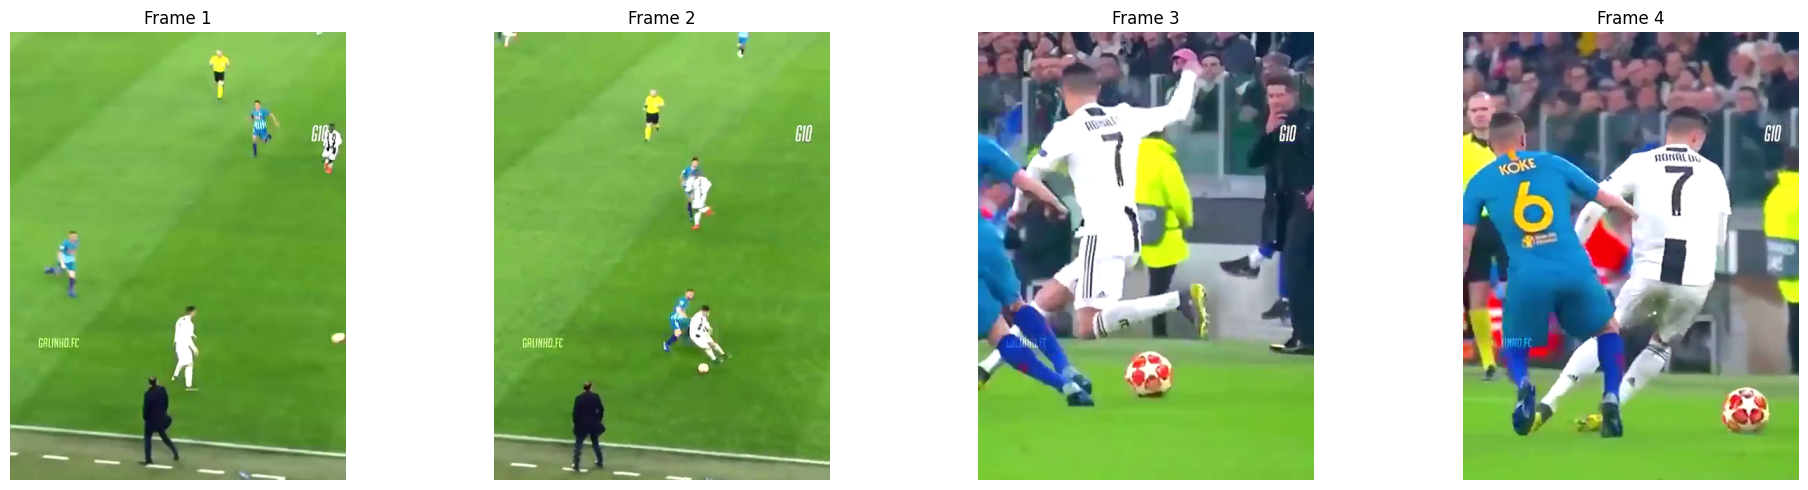

In [33]:
generate_captions_and_show_frames("/kaggle/input/extended-msvdclips-dataset/Extended Dataset/zzzzfootball1.avi")

### Extra Videos


0: 480x640 1 dog, 77.9ms
Speed: 4.8ms preprocess, 77.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.7ms
Speed: 1.6ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.8ms
Speed: 1.7ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)



ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0: 480x640 (no detections), 8.3ms
Speed: 2.3ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.5ms
Speed: 1.6ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 umbrella, 6.9ms
Speed: 1.7ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 umbrella, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
The video features several objects including person, umbrella, car, and dog. The audio could not be t

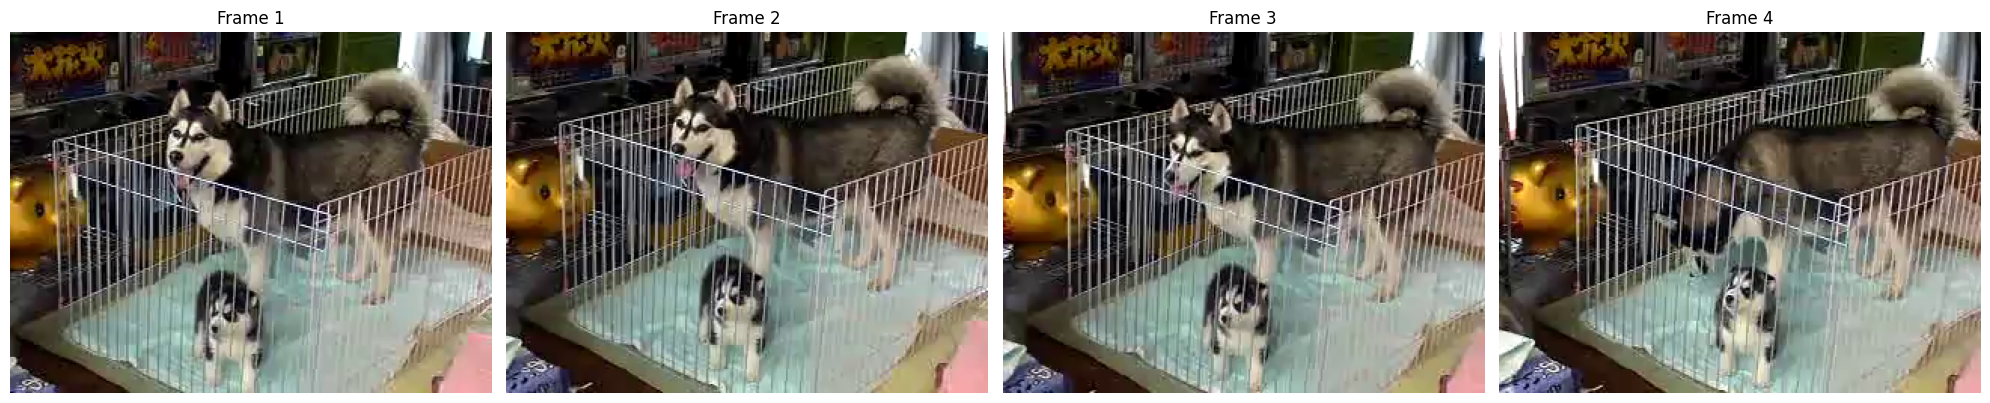

In [34]:
input2="/kaggle/input/extended-msvdclips-dataset/Extended Dataset/-FugkxLmGO4_5_16.avi"
generate_captions_and_show_frames(input2)


0: 384x640 2 persons, 1 cup, 1 spoon, 1 bowl, 4 carrots, 91.9ms
Speed: 2.8ms preprocess, 91.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 bottle, 2 spoons, 1 bowl, 4 carrots, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e


0: 384x640 3 spoons, 1 bowl, 7 carrots, 11.3ms
Speed: 1.5ms preprocess, 11.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 cup, 2 spoons, 3 bowls, 5 carrots, 1 dining table, 8.9ms
Speed: 1.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 cup, 2 forks, 2 bowls, 4 carrots, 1 dining table, 9.7ms
Speed: 3.9ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 1 bottle, 1 cup, 1 knife, 3 bowls, 1 microwave, 8.8ms
Speed: 1.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 carrots, 12.9ms
Speed: 2.6ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 tie, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
The video features several objects including knife, person, fork, cup, bottle, ca

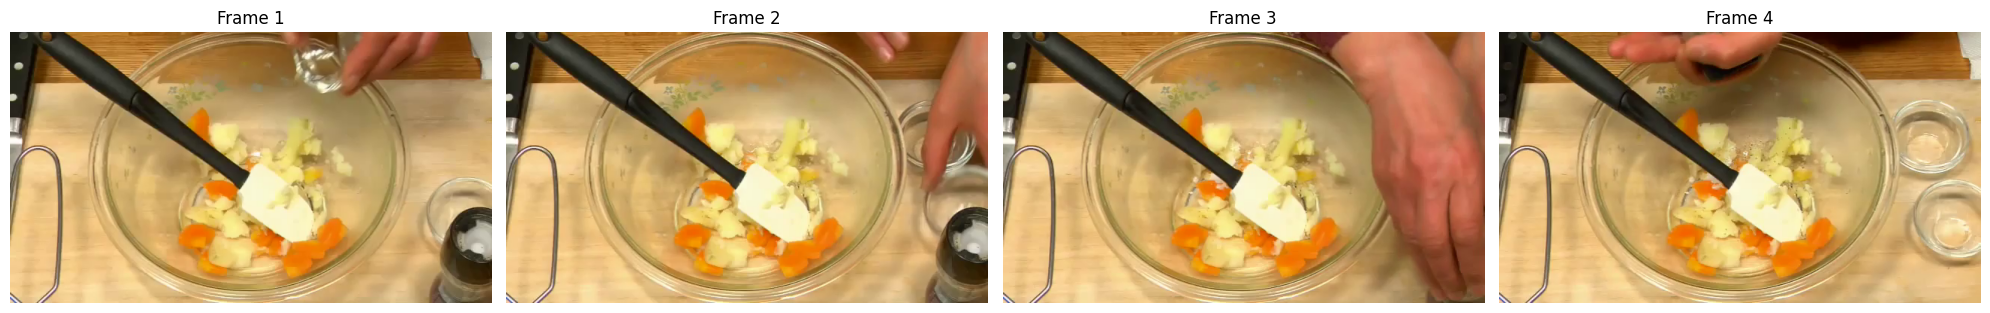

In [35]:
input3="/kaggle/input/extended-msvdclips-dataset/Extended Dataset/-_hbPLsZvvo_172_179.avi"
generate_captions_and_show_frames(input3)

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e


0: 480x640 1 person, 7.8ms
Speed: 3.5ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 teddy bear, 6.6ms
Speed: 1.6ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 toilet, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess pe

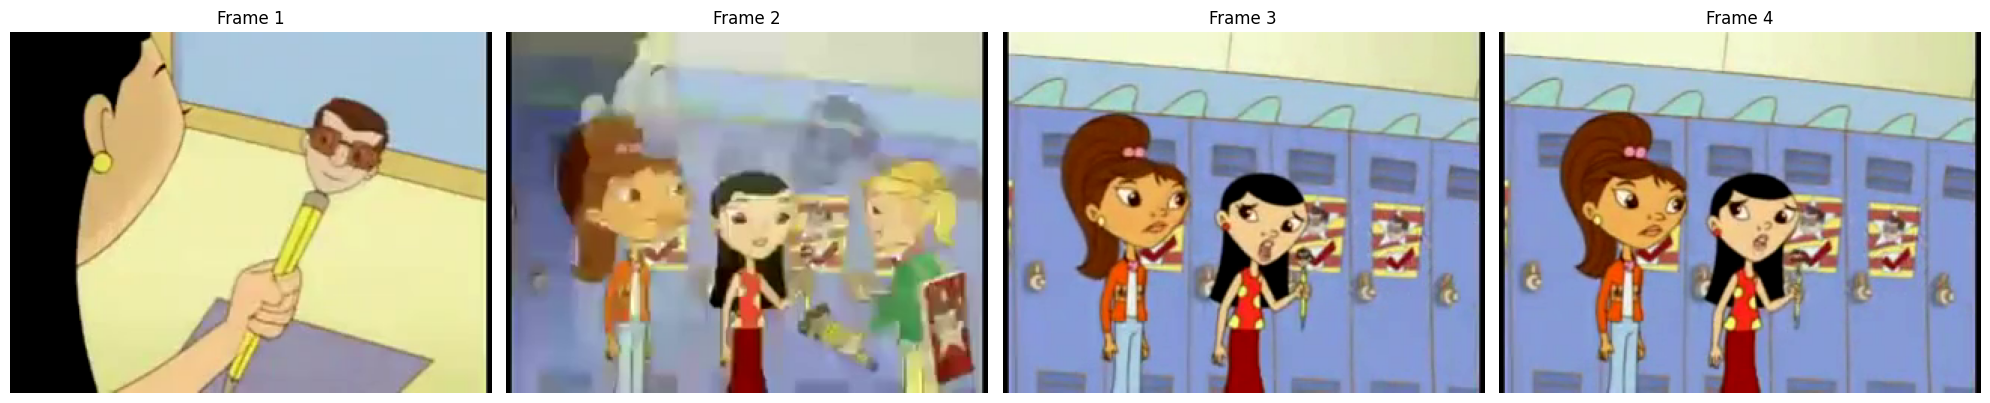

In [36]:
input4="/kaggle/input/msrvtt/TrainValVideo/video1003.mp4"
generate_captions_and_show_frames(input4)